# Modelo de Rede Neural de Recorrência

## Passo 1: Configuração do Ambiente no Google Colab

In [2]:
# Importar bibliotecas necessárias
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print ("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## Passo 2: Preparação do Conjunto de Dados

In [3]:
# Conjunto de dados de treinamento (pequeno e simplificado)
textos_treinamento = [
    "eu gosto de programar em python",
    "python é uma linguagem poderosa",
    "programar é divertido com python",
    "aprenda python e seja feliz",
    "gosto de aprender coisas novas"
]
print(f"Textos de treinamento: {textos_treinamento}")

Textos de treinamento: ['eu gosto de programar em python', 'python é uma linguagem poderosa', 'programar é divertido com python', 'aprenda python e seja feliz', 'gosto de aprender coisas novas']


In [4]:
# Inicializar o Tokenizer
tokenizer = Tokenizer()

# Construir o vocabulário a partir dos textos
tokenizer.fit_on_texts(textos_treinamento)

# Converter textos em sequências de números
sequencias = tokenizer.texts_to_sequences(textos_treinamento)

# Imprimir o vocabulário e as sequências geradas
print(f"\nVocabulário (palavra: índice): {tokenizer.word_index}")
print(f"Sequências numéricas dos textos: {sequencias}")

# Calcular o tamanho do vocabulário (+1 para incluir o 0 de padding)
total_palavras = len(tokenizer.word_index) + 1
print(f"Tamanho total do vocabulário: {total_palavras}")


Vocabulário (palavra: índice): {'python': 1, 'gosto': 2, 'de': 3, 'programar': 4, 'é': 5, 'eu': 6, 'em': 7, 'uma': 8, 'linguagem': 9, 'poderosa': 10, 'divertido': 11, 'com': 12, 'aprenda': 13, 'e': 14, 'seja': 15, 'feliz': 16, 'aprender': 17, 'coisas': 18, 'novas': 19}
Sequências numéricas dos textos: [[6, 2, 3, 4, 7, 1], [1, 5, 8, 9, 10], [4, 5, 11, 12, 1], [13, 1, 14, 15, 16], [2, 3, 17, 18, 19]]
Tamanho total do vocabulário: 20


In [6]:
# Preparar Entradas (X) e Saídas (y) para a previsão da próxima palavra
# a entrada (X) será uma sequência de palavras, e a saída (y) será a palavra seguinte.
# Determinar o comprimento máximo das sequências para padding
max_comprimento = max(len(seq) for seq in sequencias)
print(f"\nComprimento máximo das sequências antes do padding: {max_comprimento}")

# Criar pares de entrada (sequência parcial) e saída (próxima palavra)
# Ex: "eu gosto de programar" -> "em"
#     "gosto de programar em" -> "python"
entradas_X = []
saidas_y = []
for seq in sequencias:
    for i in range(1, len(seq)):
        entradas_X.append(seq[:i]) # A sequência até a palavra atual
        saidas_y.append(seq[i])    # A próxima palavra

print(f"Exemplo de entradas_x (parcial): {entradas_X[0:5]}")
print(f"Exemplo de entradas_x (parcial): {saidas_y[0:5]}")

# Padronizar o comprimento das sequências de entrada
# Todas as sequências de entrada precisam ter o mesmo comprimento para a RNN
entradas_x_padded = pad_sequences(entradas_X, maxlen=max_comprimento -1, padding='pre')
# O maxlen é "max_comprimento - 1" por que a saída "y" é a última palavra, então X sempre terá 1 palavra a menos.

# Converter as saídas para o formato one-hot encoding
# Isso é necessário para a camada de saída de RNN (softmax)
saidas_y_one_hot = tf.keras.utils.to_categorical(saidas_y, num_classes=total_palavras)

print(f"\nExemplo de entradas_X_padded (após padding e truncagem): \n{entradas_x_padded[0:5]}")
print(f"Exemplo de saídas_y_one_hot (após one-hot encoding): \n{saidas_y_one_hot[0:5]}")
print(f"Formato final das entradas (X): {entradas_x_padded.shape}")
print(f"Formato final das saídas (y): {saidas_y_one_hot.shape}")


Comprimento máximo das sequências antes do padding: 6
Exemplo de entradas_x (parcial): [[6], [6, 2], [6, 2, 3], [6, 2, 3, 4], [6, 2, 3, 4, 7]]
Exemplo de entradas_x (parcial): [2, 3, 4, 7, 1]

Exemplo de entradas_X_padded (após padding e truncagem): 
[[0 0 0 0 6]
 [0 0 0 6 2]
 [0 0 6 2 3]
 [0 6 2 3 4]
 [6 2 3 4 7]]
Exemplo de saídas_y_one_hot (após one-hot encoding): 
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Formato final das entradas (X): (21, 5)
Formato final das saídas (y): (21, 20)


## Passo 3: Construção do Modelo RNN

In [8]:
# 1. Definindo o modelo
# Definir a arquitetura do modelo RNN
modelo_rnn = Sequential()

# Camada de Embedding:
# total_palavras: tamanho do vocabulário
# 10: dimensão do vetor de embedding (quantas características queremos para cada palavra)
# input_length: comprimento das sequências de entrada (maxlen - 1)
modelo_rnn.add(Embedding(total_palavras, 10, input_length=entradas_x_padded.shape[1]))

# Camada SimpleRNN:
# 32: número de unidades (neurônios) na camada recorrente. Este é o tamanho do estado oculto.
modelo_rnn.add(SimpleRNN(32))

# Camada Densa de Saída:
# total_palavras: número de neurônios de saída (um para cada palavra no vocabulário)
# activation='softmax': função de ativação para probabilidade (soma 1 para todas as palavras)
modelo_rnn.add(Dense(total_palavras, activation='softmax'))

# Compilar o modelo
modelo_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Exibir um resumo da arquitetura do modelo
modelo_rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Passo 4: Treinamento do Modelo

In [9]:
# Treinando o modelo
print("\nIniciando o treinamento do modelo RNN...")
modelo_rnn.fit(entradas_x_padded, saidas_y_one_hot, epochs=100, verbose=1)
    # epochs: quantas vezes o modelo verá todo o conjunto de dados
    # verbose: 1 para mostrar o progresso do treinamento
print("Treinamento concluído")


Iniciando o treinamento do modelo RNN...
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0000e+00 - loss: 2.9946
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.0000e+00 - loss: 2.9858
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0476 - loss: 2.9770
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.0952 - loss: 2.9680
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.0952 - loss: 2.9588
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1429 - loss: 2.9493
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1905 - loss: 2.9396
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.1905 - loss: 2.9294
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1905 - loss: 2.9189
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.1905 - loss: 2.9079
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1905 - loss: 2.8964
Epoch 12/100
1/1 ━━━━━━━━

## Passo 5: Usar o Modelo para Previsão

In [10]:
# 1. Função de Previsão:
def prever_proxima_palavra(modelo, tokenizer, max_seq_len, texto_base):
    """
    Prevê a próxima palavra dado um texto base.
    """
    # Converter o texto base para sequência numérica
    sequencia_numerica = tokenizer.texts_to_sequences([texto_base])[0]

    # Padronizar o comprimento da sequência de entrada (precisa ter o mesmo formato que o treinamento)
    # Atenção: max_seq_len deve ser o comprimento que as *entradas* foram pad_sequenciadas
    sequencia_padded = pad_sequences([sequencia_numerica], maxlen=max_seq_len, padding='pre')

    # Fazer a previsão
    previsao_probabilidades = modelo.predict(sequencia_padded, verbose=0)[0]

    # Obter o índice da palavra com a maior probabilidade
    indice_palavra_prevista = np.argmax(previsao_probabilidades)

    # Converter o índice de volta para a palavra
    for palavra, indice in tokenizer.word_index.items():
        if indice == indice_palavra_prevista:
            return palavra

    return None  # Caso a palavra não seja encontrada (improvável com o vocabulário ajustado)

# Comprimento de entrada esperado pelo modelo
# entradas_X_padded.shape[1] é o maxlen que usamos no pad_sequences para X
comprimento_entrada_modelo = entradas_x_padded.shape[1]

# Testar o modelo com novas frases
print("\n--- Testando o Modelo RNN ---\n")

texto_teste_1 = "eu gosto de"
proxima_1 = prever_proxima_palavra(modelo_rnn, tokenizer, comprimento_entrada_modelo, texto_teste_1)
print(f"Texto: '{texto_teste_1}' -> Próxima palavra prevista: '{proxima_1}'")

texto_teste_2 = "python é uma"
proxima_2 = prever_proxima_palavra(modelo_rnn, tokenizer, comprimento_entrada_modelo, texto_teste_2)
print(f"Texto: '{texto_teste_2}' -> Próxima palavra prevista: '{proxima_2}'")

texto_teste_3 = "programar é divertido"
proxima_3 = prever_proxima_palavra(modelo_rnn, tokenizer, comprimento_entrada_modelo, texto_teste_3)
print(f"Texto: '{texto_teste_3}' -> Próxima palavra prevista: '{proxima_3}'")

texto_teste_4 = "aprenda python e"
proxima_4 = prever_proxima_palavra(modelo_rnn, tokenizer, comprimento_entrada_modelo, texto_teste_4)
print(f"Texto: '{texto_teste_4}' -> Próxima palavra prevista: '{proxima_4}'")

# Exemplo com palavra fora do vocabulário (ou sequência que o modelo nunca viu antes)
texto_teste_5 = "o sol brilha no"
# "o", "sol" e "brilha" não estão no vocabulário
proxima_5 = prever_proxima_palavra(modelo_rnn, tokenizer, comprimento_entrada_modelo, texto_teste_5)
print(f"Texto: '{texto_teste_5}' -> Próxima palavra prevista: '{proxima_5}' (Pode ser inesperada devido a palavras desconhecidas)")



--- Testando o Modelo RNN ---

Texto: 'eu gosto de' -> Próxima palavra prevista: 'programar'
Texto: 'python é uma' -> Próxima palavra prevista: 'linguagem'
Texto: 'programar é divertido' -> Próxima palavra prevista: 'com'
Texto: 'aprenda python e' -> Próxima palavra prevista: 'seja'
Texto: 'o sol brilha no' -> Próxima palavra prevista: 'é' (Pode ser inesperada devido a palavras desconhecidas)


# Modelo de Rede Neural Long Short-Term Memory

## Passo 1: Configuração do Ambiente e Importação de Bibliotecas

In [12]:
# Importar bibliotecas necessárias
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Bibliotecas Importadas com sucesso!")

Bibliotecas Importadas com sucesso!


## Passo 2: Preparação do Conjunto de Dados de Análise de Sentimentos

In [13]:
# 1. Definir o Conjunto de Dados (Frases e Rótulos) para análise de sentimentos
dados_sentimento = [
    ("este filme é ótimo e divertido", "positivo"),
    ("Adorei muito, muito bom!", "positivo"),
    ("foi uma ótima atuação dos atores", "positivo"),
    ("o roteiro é fraco e chato", "negativo"),
    ("Gostei do enredo, mas não do produto", "negativo"),
    ("uma perda de tempo horrível", "negativo"),
    ("filme terrível, inacabável", "negativo"),
    ("Não gostei de nenhum dos finais", "negativo"),
    ("excelente serviço, muito eficiente", "positivo"),
    ("decepcionante, muito ruim", "negativo"),
    ("personagem cativante e emocionante", "positivo"),
    ("O plano de fundo é interessante", "positivo"),
    ("péssima qualidade várias vezes", "negativo"),
    ("interface é confusa e difícil", "negativo"),
    ("serviço super útil e rápido", "positivo")
]

textos = [dado[0] for dado in dados_sentimento]
sentimentos = [dado[1] for dado in dados_sentimento]

print(f"Total de frases: {len(textos)}")
print(f"Exemplo de textos: {textos[:3]}")
print(f"Exemplo de sentimentos: {sentimentos[:3]}")


Total de frases: 15
Exemplo de textos: ['este filme é ótimo e divertido', 'Adorei muito, muito bom!', 'foi uma ótima atuação dos atores']
Exemplo de sentimentos: ['positivo', 'positivo', 'positivo']


In [14]:
# 2. Mapear Sentimentos para Números: converter "positivo" e "negativo" para 0 e 1.
mapeamento_sentimento = {'negativo': 0, 'positivo': 1}
rotulos_numericos = np.array([mapeamento_sentimento[s] for s in sentimentos])

print(f"\nSentimentos mapeados para números: {rotulos_numericos}")


Sentimentos mapeados para números: [1 1 1 0 0 0 0 0 1 0 1 1 0 0 1]


In [15]:
# 3. Tokenização do Texto
tokenizer = Tokenizer(num_words=None, oov_token="<unk>")
# num_words=None para pegar todo o vocabulário
# oov_token para palavras desconhecidas
tokenizer.fit_on_texts(textos)
sequencias_numericas = tokenizer.texts_to_sequences(textos)

total_palavras_vocab = len(tokenizer.word_index) + 1 # +1 para o 0 de padding/OOV

print(f"\nVocabulário (palavra: índice): {tokenizer.word_index}")
print(f"Sequências numéricas das frases: {sequencias_numericas}")
print(f"Tamanho total do vocabulário: {total_palavras_vocab}")


Vocabulário (palavra: índice): {'<unk>': 1, 'e': 2, 'é': 3, 'muito': 4, 'de': 5, 'filme': 6, 'uma': 7, 'dos': 8, 'o': 9, 'gostei': 10, 'do': 11, 'não': 12, 'serviço': 13, 'este': 14, 'ótimo': 15, 'divertido': 16, 'adorei': 17, 'bom': 18, 'foi': 19, 'ótima': 20, 'atuação': 21, 'atores': 22, 'roteiro': 23, 'fraco': 24, 'chato': 25, 'enredo': 26, 'mas': 27, 'produto': 28, 'perda': 29, 'tempo': 30, 'horrível': 31, 'terrível': 32, 'inacabável': 33, 'nenhum': 34, 'finais': 35, 'excelente': 36, 'eficiente': 37, 'decepcionante': 38, 'ruim': 39, 'personagem': 40, 'cativante': 41, 'emocionante': 42, 'plano': 43, 'fundo': 44, 'interessante': 45, 'péssima': 46, 'qualidade': 47, 'várias': 48, 'vezes': 49, 'interface': 50, 'confusa': 51, 'difícil': 52, 'super': 53, 'útil': 54, 'rápido': 55}
Sequências numéricas das frases: [[14, 6, 3, 15, 2, 16], [17, 4, 4, 18], [19, 7, 20, 21, 8, 22], [9, 23, 3, 24, 2, 25], [10, 11, 26, 27, 12, 11, 28], [7, 29, 5, 30, 31], [6, 32, 33], [12, 10, 5, 34, 8, 35], [36,

In [16]:
# 4. Padronizar o comprimento das sequências
# Encontrar o comprimento da frase mais longa para padronizar
max_len = max([len(s) for s in sequencias_numericas])
print(f"\nComprimento máximo das sequências: {max_len}")

entradas_X_padded = pad_sequences(sequencias_numericas, maxlen=max_len, padding='post') # 'post' para adicionar zeros no final
print(f"Sequências após padding: \n{entradas_X_padded}")


Comprimento máximo das sequências: 7
Sequências após padding: 
[[14  6  3 15  2 16  0]
 [17  4  4 18  0  0  0]
 [19  7 20 21  8 22  0]
 [ 9 23  3 24  2 25  0]
 [10 11 26 27 12 11 28]
 [ 7 29  5 30 31  0  0]
 [ 6 32 33  0  0  0  0]
 [12 10  5 34  8 35  0]
 [36 13  4 37  0  0  0]
 [38  4 39  0  0  0  0]
 [40 41  2 42  0  0  0]
 [ 9 43  5 44  3 45  0]
 [46 47 48 49  0  0  0]
 [50  3 51  2 52  0  0]
 [13 53 54  2 55  0  0]]


In [17]:
# 5. Dividir os dados em conjuntos de treinamento e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(
    entradas_X_padded, rotulos_numericos, test_size=0.2, random_state=42, stratify=rotulos_numericos
)

print(f"\nShape de X_treino: {X_treino.shape}")
print(f"Shape de X_teste: {X_teste.shape}")
print(f"Shape de y_treino: {y_treino.shape}")
print(f"Shape de y_teste: {y_teste.shape}")


Shape de X_treino: (12, 7)
Shape de X_teste: (3, 7)
Shape de y_treino: (12,)
Shape de y_teste: (3,)


## Passo 3: Construção do Modelo LSTM

In [18]:
# Definir a arquitetura do modelo LSTM
modelo_lstm = Sequential()

# Camada de Embedding: Converte os índices numéricos das palavras em vetores densos.
# total_palavras_vocab: tamanho do vocabulário
# 50: dimensão do vetor de embedding (pode ser ajustado)
# input_length: comprimento padronizado das sequências (max_len)
modelo_lstm.add(Embedding(total_palavras_vocab, 50, input_length=max_len))

# Camada LSTM:
# 64: número de unidades (neurônios) na camada LSTM. Define o tamanho do estado oculto e da célula de memória.
# dropout: Um tipo de regularização para evitar overfitting (descarta aleatoriamente neurônios durante o treinamento).
# recurrent_dropout: Dropout aplicado nas conexões recorrentes da LSTM.
modelo_lstm.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))

# Camada Densa de Saída:
# 1: Um único neurônio de saída, pois é um problema de classificação binária (positivo/negativo).
# activation='sigmoid': Função de ativação para classificação binária (produz um valor entre 0 e 1).
modelo_lstm.add(Dense(1, activation='sigmoid'))

# Compilar o modelo
modelo_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Exibir um resumo da arquitetura do modelo
modelo_lstm.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Passo 4: Treinamento e Avaliação do Modelo


Iniciando o treinamento do modelo LSTM...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.4667 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5486 - loss: 0.6907 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2569 - loss: 0.6971 - val_accuracy: 0.5000 - val_loss: 0.6956
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8028 - loss: 0.6845 - val_accuracy: 0.5000 - val_loss: 0.6974
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8764 - loss: 0.6808 - val_accuracy: 0.5000 - val_loss: 0.7001
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8222 - loss: 0.6724 - val_accuracy: 0.0000e+00 - val_loss: 0.7044
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9181 - loss: 0.6601 - val_accuracy: 0.0000e+00 - val_loss: 0.7112
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9667 - los

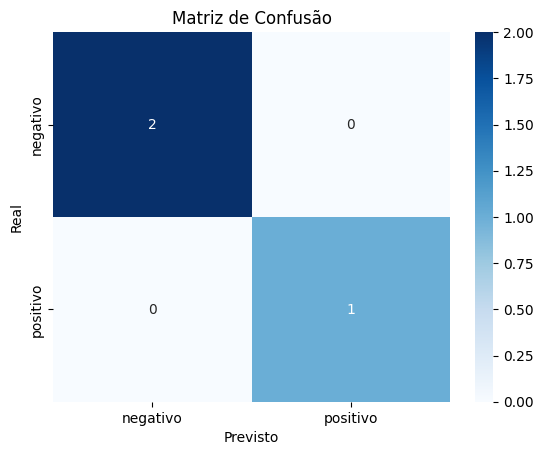

In [19]:
# Treinar o modelo
print("\nIniciando o treinamento do modelo LSTM...")
historico = modelo_lstm.fit(
    X_treino, y_treino,
    epochs=50, # Reduzi para 50 epochs para um treinamento mais rápido no exemplo. Pode ser aumentado.
    batch_size=2, # Pequeno batch_size para dataset pequeno.
    validation_split=0.1, # Usar 10% do treino para validação
    verbose=1
)
print("Treinamento concluído!")

# Avalia o modelo no conjunto de teste
perda, acuracia = modelo_lstm.evaluate(X_teste, y_teste, verbose=0)
print(f"\nAcurácia do modelo no conjunto de teste: {acuracia*100:.2f}%")
print(f"Perda do modelo no conjunto de teste: {perda:.4f}")

# Fazer previsões no conjunto de teste
y_pred_prob = modelo_lstm.predict(X_teste)
y_pred_classes = (y_pred_prob > 0.5).astype(int) # Converter probabilidades para 0 ou 1

print("\n-- Relatório de Classificação --")
print(classification_report(y_teste, y_pred_classes, target_names=['negativo', 'positivo']))

print("\n-- Matriz de Confusão --")
cm = confusion_matrix(y_teste, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negativo', 'positivo'], yticklabels=['negativo', 'positivo'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


## Passo 5: Testar o Modelo com Novas Frases

In [20]:
# Passo 5: Testar o Modelo com Novas Frases

# utilizando o modelo treinado
def prever_sentimento(modelo, tokenizer, max_seq_len, frase_nova, mapeamento_sentimento):
    """
    Prevê o sentimento de uma nova frase.
    """
    # Converter a frase para sequência numérica
    sequencia_numerica = tokenizer.texts_to_sequences([frase_nova])

    # Se a frase tem palavras desconhecidas, o tokenizer pode retornar uma lista vazia ou valores 0
    if not sequencia_numerica:
        print(f"Aviso: a frase '{frase_nova}' contém apenas palavras desconhecidas.")
        return "Desconhecido"  # Ou outra indicação

    sequencia_numerica = sequencia_numerica[0]  # Pega a primeira (e única) sequência

    # Padronizar o comprimento da sequência de entrada
    sequencia_padded = pad_sequences([sequencia_numerica], maxlen=max_seq_len, padding='post')

    # Fazer a previsão (probabilidade)
    probabilidade_positiva = modelo.predict(sequencia_padded, verbose=0)[0][0]

    # Inverter o mapeamento para obter o nome do sentimento
    mapeamento_inverso = {v: k for k, v in mapeamento_sentimento.items()}

    # Classificar com base no limiar de 0.5
    if probabilidade_positiva >= 0.5:
        return mapeamento_inverso[1]  # 'positivo'
    else:
        return mapeamento_inverso[0]  # 'negativo'


# Testar o modelo com novas frases
print("\n--- Testando Modelo LSTM com Novas Frases ---")

frase_nova_1 = "gostei muito do filme, excelente!"
sentimento_1 = prever_sentimento(modelo_lstm, tokenizer, max_len, frase_nova_1, mapeamento_sentimento)
print(f"Frase: '{frase_nova_1}' -> Sentimento previsto: {sentimento_1}")

frase_nova_2 = "odiei o livro, muito entediante"
sentimento_2 = prever_sentimento(modelo_lstm, tokenizer, max_len, frase_nova_2, mapeamento_sentimento)
print(f"Frase: '{frase_nova_2}' -> Sentimento previsto: {sentimento_2}")

frase_nova_3 = "a aula de pln é ótima"
sentimento_3 = prever_sentimento(modelo_lstm, tokenizer, max_len, frase_nova_3, mapeamento_sentimento)
print(f"Frase: '{frase_nova_3}' -> Sentimento previsto: {sentimento_3}")

frase_nova_4 = "o atendimento foi péssimo"
sentimento_4 = prever_sentimento(modelo_lstm, tokenizer, max_len, frase_nova_4, mapeamento_sentimento)
print(f"Frase: '{frase_nova_4}' -> Sentimento previsto: {sentimento_4}")

frase_nova_5 = "esse produto não vale a pena, é caro"
sentimento_5 = prever_sentimento(modelo_lstm, tokenizer, max_len, frase_nova_5, mapeamento_sentimento)
print(f"Frase: '{frase_nova_5}' -> Sentimento previsto: {sentimento_5}")

frase_nova_6 = "o filme é legal"  # Frase curta e ambígua para um modelo pequeno
sentimento_6 = prever_sentimento(modelo_lstm, tokenizer, max_len, frase_nova_6, mapeamento_sentimento)
print(f"Frase: '{frase_nova_6}' -> Sentimento previsto: {sentimento_6}")

frase_nova_7 = "isso é horrível, que tristeza"
sentimento_7 = prever_sentimento(modelo_lstm, tokenizer, max_len, frase_nova_7, mapeamento_sentimento)
print(f"Frase: '{frase_nova_7}' -> Sentimento previsto: {sentimento_7}")



--- Testando Modelo LSTM com Novas Frases ---
Frase: 'gostei muito do filme, excelente!' -> Sentimento previsto: negativo
Frase: 'odiei o livro, muito entediante' -> Sentimento previsto: negativo
Frase: 'a aula de pln é ótima' -> Sentimento previsto: negativo
Frase: 'o atendimento foi péssimo' -> Sentimento previsto: positivo
Frase: 'esse produto não vale a pena, é caro' -> Sentimento previsto: negativo
Frase: 'o filme é legal' -> Sentimento previsto: negativo
Frase: 'isso é horrível, que tristeza' -> Sentimento previsto: negativo
